## sprint17 augmentation

## 【問題1】自作データセットでの分類の学習

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import math

from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.models import Model

Using TensorFlow backend.


In [2]:
import numpy  as np
import os
import glob 
import re
from PIL import Image

In [3]:
img_list = ['training/dog1.jpg',
            'training/dog2.jpg',
            'training/dog3.jpg',
            'training/dog4.jpg',
            'training/dog5.jpg',
            'training/cat1.jpg',
            'training/cat2.jpg',
            'training/cat3.jpg',
            'training/cat4.jpg',
            'training/cat5.jpg',]


### まずは通常のresnet50 による推論をする（犬と猫は概ね認識していそう。ノーマライズをしないほうが正しく機能しそう）。
https://keras.io/ja/applications/#resnet50

In [61]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import plot_model
import numpy as np

resnet1 = ResNet50(include_top=True, input_shape=(224, 224, 3), weights="imagenet")
#plot_model(m, to_file='C:/image/resnet50.png')
resnet1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [52]:
dog_img_array = np.empty((0,224,224,3))
cat_img_array = np.empty((0,224,224,3))

for img in img_list:
    if re.search('dog', img):
        dog_img_ = Image.open(img)
        dog_img_ = dog_img_.resize((224, 224))
        dog_img = np.array(dog_img_)
        dog_img = dog_img.reshape((1,224,224,3))        
        dog_img_array = np.concatenate([dog_img_array, dog_img], axis = 0)
    if re.search('cat', img):        
        cat_img_ = Image.open(img)
        cat_img_ = cat_img_.resize((224, 224))
        cat_img = np.array(cat_img_)
        cat_img = cat_img.reshape((1,224,224,3))
        cat_img_array = np.concatenate([cat_img_array, cat_img], axis = 0)

img_array = np.concatenate([dog_img_array,cat_img_array,])

x = preprocess_input(img_array)

preds = resnet1.predict(x)

for i in range(len(img_array)):
    print('Predicted:', decode_predictions(preds, top=2)[i])

Predicted: [('n02099601', 'golden_retriever', 0.35549453), ('n02112137', 'chow', 0.23045208)]
Predicted: [('n02113186', 'Cardigan', 0.5969776), ('n02113023', 'Pembroke', 0.3426647)]
Predicted: [('n02108551', 'Tibetan_mastiff', 0.32039165), ('n02105056', 'groenendael', 0.14365716)]
Predicted: [('n02109961', 'Eskimo_dog', 0.4385657), ('n02111889', 'Samoyed', 0.16370274)]
Predicted: [('n02085620', 'Chihuahua', 0.6506284), ('n02112018', 'Pomeranian', 0.19192885)]
Predicted: [('n02124075', 'Egyptian_cat', 0.3010625), ('n02123045', 'tabby', 0.12687562)]
Predicted: [('n02109961', 'Eskimo_dog', 0.18005235), ('n02106166', 'Border_collie', 0.08540428)]
Predicted: [('n02123045', 'tabby', 0.74080116), ('n02124075', 'Egyptian_cat', 0.12802185)]
Predicted: [('n02124075', 'Egyptian_cat', 0.14522257), ('n02123159', 'tiger_cat', 0.13786602)]
Predicted: [('n02110806', 'basenji', 0.22444987), ('n02113186', 'Cardigan', 0.12998958)]


### つぎにResNet50の末尾の全結合層を取り除き（include_top=False）、犬と猫を分類するための全結合層を付け加えた推論をする。

＜メモ＞
https://keras.io/ja/applications/#resnet50
Applications  
Kerasの応用は事前学習した重みを利用可能な深層学習のモデルです． これらのモデルは予測，特徴量抽出そしてfine-tuningのために利用できます．  
モデルをインスタンス化すると重みは自動的にダウンロードされます．重みは~/.keras/models/に格納されます．  

In [4]:
# np.resizeは使ってはならない。

dog_img_array = np.empty((0,224,224,3))
cat_img_array = np.empty((0,224,224,3))

for img in img_list:
    if re.search('dog', img):
        dog_img_ = Image.open(img)
        dog_img_ = dog_img_.resize((224, 224))
        dog_img = np.array(dog_img_)
        #dog_img = dog_img/255. 
        dog_img = dog_img.reshape((1,224,224,3))        
        dog_img_array = np.concatenate([dog_img_array, dog_img], axis = 0)
    if re.search('cat', img):        
        cat_img_ = Image.open(img)
        cat_img_ = cat_img_.resize((224, 224))
        cat_img = np.array(cat_img_)
        #cat_img = cat_img/255.
        cat_img = cat_img.reshape((1,224,224,3))
        cat_img_array = np.concatenate([cat_img_array, cat_img], axis = 0)

img_array = np.concatenate([dog_img_array,cat_img_array,])

In [72]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import plot_model
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation

resnet2= ResNet50(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
#plot_model(m, to_file='C:/image/resnet50.png')

In [78]:
avgp = GlobalAveragePooling2D()(resnet2.output)
model_output = Dense(2, activation="softmax")(avgp)
model = Model(resnet2.input, model_output)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [77]:
# flattenよりもGrobalAveragePooling2Dの方が、パラメータ数が少なく過学習が抑えられる。
# h = Flatten()(resnet2.output)
# model_output = Dense(2, activation="softmax")(h)
# model = Model(resnet2.input, model_output)

In [25]:
#　trainデータとラベルデータを作成。trainデータは課題に沿って10枚だけ。
X_train = img_array
y_train = np.concatenate([np.zeros(5), np.ones(5)])

In [26]:
X_train.shape

(10, 224, 224, 3)

In [79]:
from keras import optimizers

optimizer = optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True)
loss="sparse_categorical_crossentropy"
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
model.fit(X_train,y_train)

Epoch 1/1
10/10 [==============================] - 77s 8s/step - loss: 0.7420 - accuracy: 0.4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


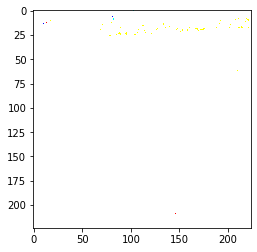

In [94]:
plt.imshow(img_array[3])

In [80]:
preds = model.predict(img_array)
preds

# 犬：０ラベル、猫：１ラベル。現状では分類精度はよくない。

array([[0.547652  , 0.45234802],
       [0.09014356, 0.90985644],
       [0.7976053 , 0.20239478],
       [0.06551712, 0.9344829 ],
       [0.17582887, 0.8241711 ],
       [0.15567107, 0.84432894],
       [0.43524808, 0.564752  ],
       [0.41027382, 0.5897262 ],
       [0.11518361, 0.8848164 ],
       [0.1436894 , 0.85631067]], dtype=float32)

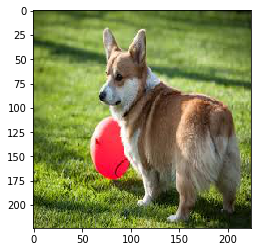

In [112]:
plt.imshow(img_array[1]/255)

In [95]:
#　訓練に使わなかった犬猫画像で推論してみる。

img_list_test = ['training/dog6.jpg',
            'training/dog7.jpg',
            'training/cat6.jpg',
            'training/cat7.jpg']

In [97]:
dog_img_array2 = np.empty((0,224,224,3))
cat_img_array2 = np.empty((0,224,224,3))

for img in img_list_test:
    if re.search('dog', img):
        dog_img_ = Image.open(img)
        dog_img_ = dog_img_.resize((224, 224))
        dog_img = np.array(dog_img_)
        #dog_img = dog_img/255. 
        dog_img = dog_img.reshape((1,224,224,3))        
        dog_img_array2 = np.concatenate([dog_img_array2, dog_img], axis = 0)
    if re.search('cat', img):        
        cat_img_ = Image.open(img)
        cat_img_ = cat_img_.resize((224, 224))
        cat_img = np.array(cat_img_)
        #cat_img = cat_img/255.
        cat_img = cat_img.reshape((1,224,224,3))
        cat_img_array2 = np.concatenate([cat_img_array2, cat_img], axis = 0)

img_array2 = np.concatenate([dog_img_array2,cat_img_array2,])

In [98]:
#　同様に、分類精度はよくない。

preds = model.predict(img_array2)
preds

array([[0.20461869, 0.7953813 ],
       [0.7204583 , 0.27954167],
       [0.6933166 , 0.3066834 ],
       [0.2421344 , 0.75786555]], dtype=float32)

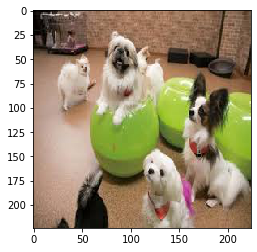

In [111]:
plt.imshow(img_array2[0]/255)

## 【問題２】分類データセットに対するデータ拡張（Ａｕｇｍｅｎｔａｔｉｏｎ）
参考：https://qiita.com/mochosan/items/00ed3589e13448496b4c

In [69]:
from keras.preprocessing import image

In [145]:
dog_img_array1 = np.empty((0,224,224,3))
cat_img_array1 = np.empty((0,224,224,3))

for img in img_list:
    if re.search('dog', img):
        dog_img_ = Image.open(img)
        dog_img_ = dog_img_.resize((224, 224))
        dog_img = np.array(dog_img_)
        dog_img = dog_img/255.
        dog_img = dog_img.reshape((1,224,224,3))        
        dog_img_array1 = np.concatenate([dog_img_array1, dog_img], axis = 0)
    if re.search('cat', img):        
        cat_img_ = Image.open(img)
        cat_img_ = cat_img_.resize((224, 224))
        cat_img = np.array(cat_img_)
        cat_img = cat_img/255.
        cat_img = cat_img.reshape((1,224,224,3))
        cat_img_array1 = np.concatenate([cat_img_array1, cat_img], axis = 0)

img_array1 = np.concatenate([dog_img_array1, cat_img_array1])

In [148]:
X_train1 = img_array1
y_train1 = np.concatenate([np.zeros(5), np.ones(5)])

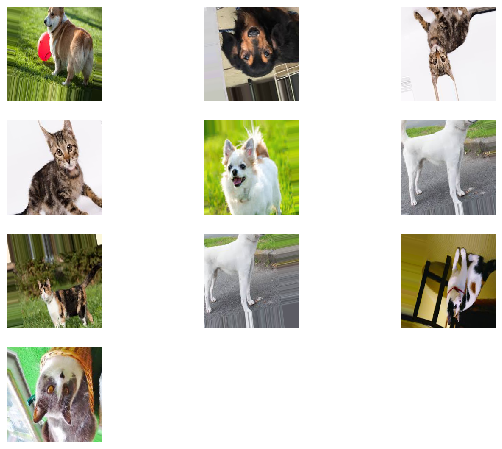

In [198]:
classes =['dogs', 'cats']

datagen = image.ImageDataGenerator(
            zca_whitening = True,
            rotation_range=22.5,
             width_shift_range=0.2,
             height_shift_range=0.2,
             zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True)

plt.figure(figsize=(10, 8))
gen1 = datagen.flow(X_train1,batch_size=10)
for i in range(10):
    batches = next(gen1)
    # (NumBatches, Height, Width, Channels) の4次元データを返す。
    # 画像として表示するため、3次元データにし、float から uint8 にキャストする。
    gen_img = batches[0]

    plt.subplot(4, 3, i + 1)
    plt.imshow(gen_img)
    plt.axis('off')
plt.show()

In [199]:
gen = datagen.flow(X_train1,y_train1,batch_size=150,save_to_dir="training/aug",save_prefix='dogcat', save_format='jpg', subset=None)
model.fit_generator(gen,epochs=4, verbose=1)

#　訓練用画像が自動生成されるのを確認できた。
#　生成される画像枚数のコントロール方法がよくわからなかった（バッチサイズ？デフォルトでは３２）。トレイン画像枚数×エポック数？
#　今回のタスクにおいて、どの手法が効果的か・・・は、準備された訓練画像やテスト画像枚数が少なく検証が困難であると考えるため省略。

Epoch 1/4
1/1 [==============================] - 11s 11s/step - loss: 0.0017 - accuracy: 1.0000
Epoch 2/4
1/1 [==============================] - 9s 9s/step - loss: 2.4173e-04 - accuracy: 1.0000
Epoch 3/4
1/1 [==============================] - 10s 10s/step - loss: 1.8411e-04 - accuracy: 1.0000
Epoch 4/4
1/1 [==============================] - 9s 9s/step - loss: 3.8078e-04 - accuracy: 1.0000


In [200]:
preds = model.predict(img_array2)
preds

array([[4.9547619e-12, 1.0000000e+00],
       [3.4879525e-12, 1.0000000e+00],
       [6.4228317e-08, 9.9999988e-01],
       [1.8802131e-09, 1.0000000e+00]], dtype=float32)

## 【問題3】物体検出データセットの用意

次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。  
《アノテーションのためのツール》  
アノテーションツールにはLabelImgなどがあります。  
tzutalin/labelImg: LabelImg is a graphical image annotation tool and label object bounding boxes in images  

＜課題メモ＞yoloではなくpascal vocを選んでほしい。  
github上のreadmeを見て進めていきましょう。  
アノテーションファイル  
Xmlパーサー。XMLから必要な関数を取り出すようにできたら理想。  
XMLは作ってほしい。  
ボックス表示。  

５枚ぐらいの犬猫画像。  
学習モデルは、分類なら何でもいい。シンプルなものがいい。  
水増しで２０枚～４０枚を作成。水増しデータを使ってトレーニング。  
明日の夕方にテストデータを配るので、それを適用。  

albumentation how to use のところにそろっている。  
Albumentation に、ＸＭＬの座標を渡してあげる。  
サーベイ論文。　２０１９．２　電通学会論文。水増しテク。  

In [4]:
!git clone https://github.com/tzutalin/labelImg

Cloning into 'labelImg'...


クローニングしたlabelImgのReadmeの、Get from PyPI but only python3.0 or aboveにてインストール。

In [15]:
!pip install labelImg

In [16]:
!labelImg

###　表示されたツールにて、犬猫10枚の画像にアノテーションを施してＸＭＬファイルを手動にて記録。

^C


In [97]:
dogcat_list = ['dog1.xml','dog2.xml','dog3.xml','dog4.xml','dog5.xml','cat1.xml','cat2.xml','cat3.xml','cat4.xml','cat5.xml']

path = "../training/dogcat/"
xml_list=[]
for i in dogcat_list:
    xml_list.append(path+i)
xml_list

['../training/dogcat/dog1.xml',
 '../training/dogcat/dog2.xml',
 '../training/dogcat/dog3.xml',
 '../training/dogcat/dog4.xml',
 '../training/dogcat/dog5.xml',
 '../training/dogcat/cat1.xml',
 '../training/dogcat/cat2.xml',
 '../training/dogcat/cat3.xml',
 '../training/dogcat/cat4.xml',
 '../training/dogcat/cat5.xml']

In [110]:
from bs4 import BeautifulSoup
print("バウンディングボックス座標表示")

for path in xml_list:
    s = open(path)
    soup = BeautifulSoup(s, "html.parser")
    print(soup.xmin,soup.ymin,soup.xmax,soup.ymax)
    s.close()

バウンディングボックス座標表示
<xmin>125</xmin> <ymin>1</ymin> <xmax>211</xmax> <ymax>84</ymax>
<xmin>79</xmin> <ymin>12</ymin> <xmax>146</xmax> <ymax>86</ymax>
<xmin>16</xmin> <ymin>15</ymin> <xmax>161</xmax> <ymax>134</ymax>
<xmin>128</xmin> <ymin>16</ymin> <xmax>211</xmax> <ymax>83</ymax>
<xmin>37</xmin> <ymin>14</ymin> <xmax>110</xmax> <ymax>95</ymax>
<xmin>62</xmin> <ymin>8</ymin> <xmax>167</xmax> <ymax>114</ymax>
<xmin>118</xmin> <ymin>19</ymin> <xmax>174</xmax> <ymax>84</ymax>
<xmin>134</xmin> <ymin>1</ymin> <xmax>224</xmax> <ymax>84</ymax>
<xmin>67</xmin> <ymin>35</ymin> <xmax>190</xmax> <ymax>151</ymax>
<xmin>170</xmin> <ymin>43</ymin> <xmax>213</xmax> <ymax>93</ymax>


In [111]:
#　参考のために単体のxmlファイルの中身を表示。

path1 = xml_list[0]
print(path1)
with open (path1) as f:
    soup1 = BeautifulSoup(f, "html.parser")
    print(soup1)

../training/dogcat/dog1.xml
<annotation>
<folder>dogcat</folder>
<filename>dog1.jpg</filename>
<path>C:\Users\hirot\training\dogcat\dog1.jpg</path>
<source/>
<database>Unknown</database>
<size>
<width>252</width>
<height>200</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>dog</name>
<pose>Unspecified</pose>
<truncated>1</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>125</xmin>
<ymin>1</ymin>
<xmax>211</xmax>
<ymax>84</ymax>
</bndbox>
</object>
</annotation>



## 【問題4】物体検出データセットに対するデータ拡張

データ拡張（Data Augmentation）を行ってください。  
前述のalbumentationsはバウンディングボックスを合わせての加工が可能です。詳細はREADME.mdを確認してください。  

In [57]:
!git clone "https://github.com/albumentations-team/albumentations"

Cloning into 'albumentations'...


In [4]:
!pip install albumentations==0.3.2

# 後のalbumentationのImport error に対応するため、albumentationのバージョンを上記のように指定する。

  Using cached https://files.pythonhosted.org/packages/ba/24/92416624af331903d78b038861afe07797bdbe3524aeca5eeed89b9d227d/opencv_python_headless-4.2.0.34-cp37-cp37m-win_amd64.whl


クローニングしたalbumentationのreadmeにおけるObject detection - example_bboxes.ipynbを参考にして、アノテーションファイル（dog1.xmlなど）のaugmentationを行う。

In [130]:
%matplotlib inline
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [119]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [125]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)


In [163]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='coco', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [164]:
# image = download_image('http://images.cocodataset.org/train2017/000000386298.jpg')
#<xmin>125</xmin> <ymin>1</ymin> <xmax>211</xmax> <ymax>84</ymax>

image = Image.open("../training/dogcat/dog1.jpg")
image = np.array(image)


In [165]:
annotations = {'image': image, 'bboxes': [[125, 1, 86, 83]], 'category_id': [18]}
category_id_to_name = {17: 'cat', 18: 'dog'}

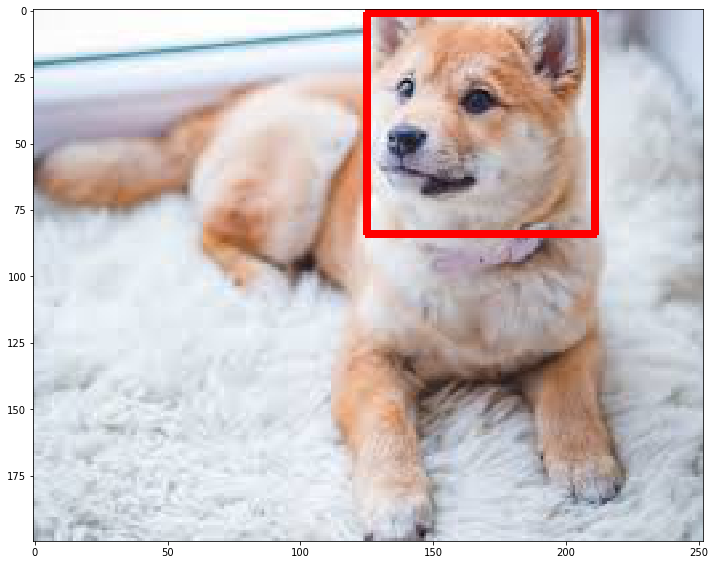

In [166]:
visualize(annotations, category_id_to_name)

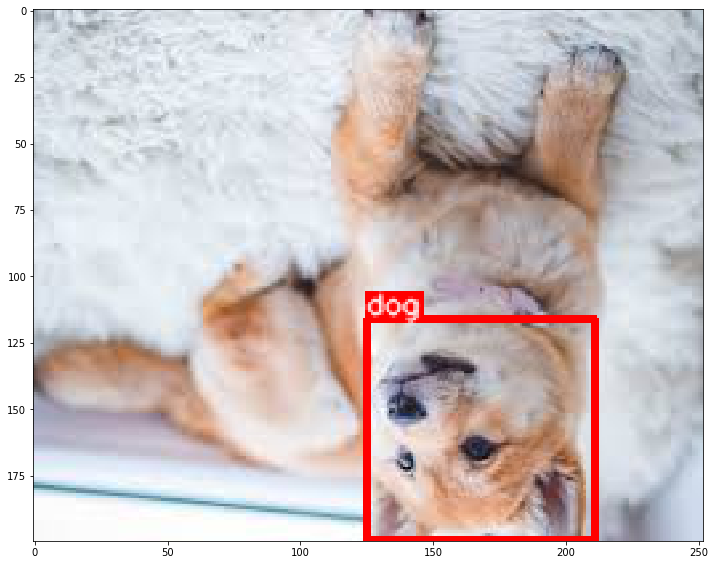

In [167]:
aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

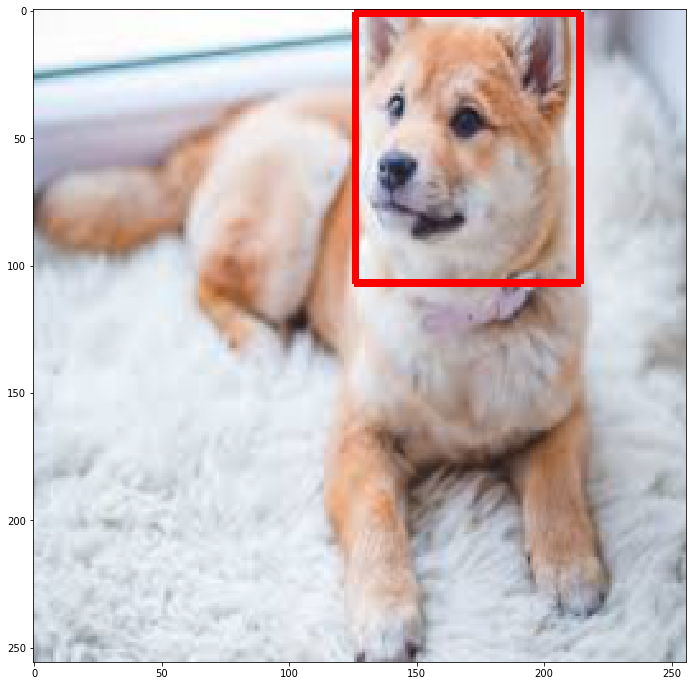

In [168]:
aug = get_aug([Resize(p=1, height=256, width=256)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

＜メモ＞アノテーションをする際には、あらかじめreshapeで形をそろえた上で行うべき。  
形状が小さくいことで、albumentationの関数が動作しないことがある。

In [106]:
cd ..

C:\Users\hirot


In [108]:
cd labelImg

C:\Users\hirot\labelImg


In [103]:
cd albumentations

C:\Users\hirot\labelImg\albumentations
